# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

In [7]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [8]:
## !pip install -qq arff2pandas

In [9]:
!pip install -q -U watermark


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [10]:
!pip install -qq -U pandas

In [11]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

/Users/Toan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy      : 1.24.3
pandas     : 2.2.3
torch      : 2.5.0
arff2pandas: not installed



In [12]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F



%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

#RANDOM_SEED = 42

In [13]:
def set_seed( RANDOM_SEED):
  np.random.seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)

In [14]:
#RANDOM_SEED = set_seed(RANDOM_SEED)

In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

By the end of this tutorial, you'll learn how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

The dataset is available on my Google Drive. Let's get it:

In [15]:
!pip install gdown


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [16]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/Users/Toan/anaconda3/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /Users/Toan/LSTM-GRU_Autoencoder/ECG5000.zip
100%|██████████████████████████████████████| 10.6M/10.6M [00:01<00:00, 9.70MB/s]


In [17]:
!unzip -qq ECG5000.zip


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [19]:


import scipy.io.arff as arff


# Load training data
with open('ECG5000_TRAIN.arff', 'r') as f:
    train_data, train_meta = arff.loadarff(f)

# Load test data
with open('ECG5000_TEST.arff', 'r') as f:
    test_data, test_meta = arff.loadarff(f)

# Convert the ARFF data to Pandas DataFrames
train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)


We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [20]:
df = pd.concat([train, test])  ## combine train and test data
df = df.sample(frac=1.0) ## shuffle df (frac = 1.0 means 100%)
df.shape

(5000, 141)

In [21]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
3285,0.129796,-0.830947,-1.508443,-2.051340,-2.475488,-2.719864,-2.630177,-2.435304,-2.338217,-2.075241,...,-3.321195,-3.634313,-3.445742,-2.617770,-1.819856,-0.939620,-0.091122,-0.286478,0.028200,b'2'
3283,-1.182588,-2.231639,-2.632605,-2.947437,-2.939669,-2.918581,-2.837352,-2.651884,-2.227810,-1.556203,...,-2.031325,-2.610457,-3.179699,-3.434878,-3.082703,-2.212933,-1.084465,-0.442920,0.101657,b'2'
3888,-0.609537,-1.183342,-1.530039,-2.144049,-2.532136,-2.756639,-2.484698,-1.983583,-1.480946,-0.973769,...,0.137930,-0.526754,-1.142398,-1.975388,-2.455193,-3.592613,-4.214078,-4.729437,-3.762342,b'2'
2076,-0.085683,-1.978614,-3.122206,-3.611664,-3.871482,-3.407097,-2.497941,-1.929080,-1.668473,-1.146618,...,1.408030,1.339557,1.334414,1.369980,0.922517,0.522571,0.215276,0.879588,0.478415,b'1'
4246,-0.613071,-1.946722,-2.571816,-2.858124,-2.822578,-2.841525,-2.563754,-2.144737,-1.498368,-0.960142,...,-0.644965,-1.229183,-1.991648,-2.880351,-3.625326,-4.207779,-3.326135,-2.599661,-1.207875,b'2'


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [22]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [23]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [24]:
df['target'] = df['target'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)



## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [25]:
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

Let's plot the results:

In [28]:
ax = sns.countplot(df.target)
#ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(class_names);

ValueError: If using all scalar values, you must pass an index

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [29]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

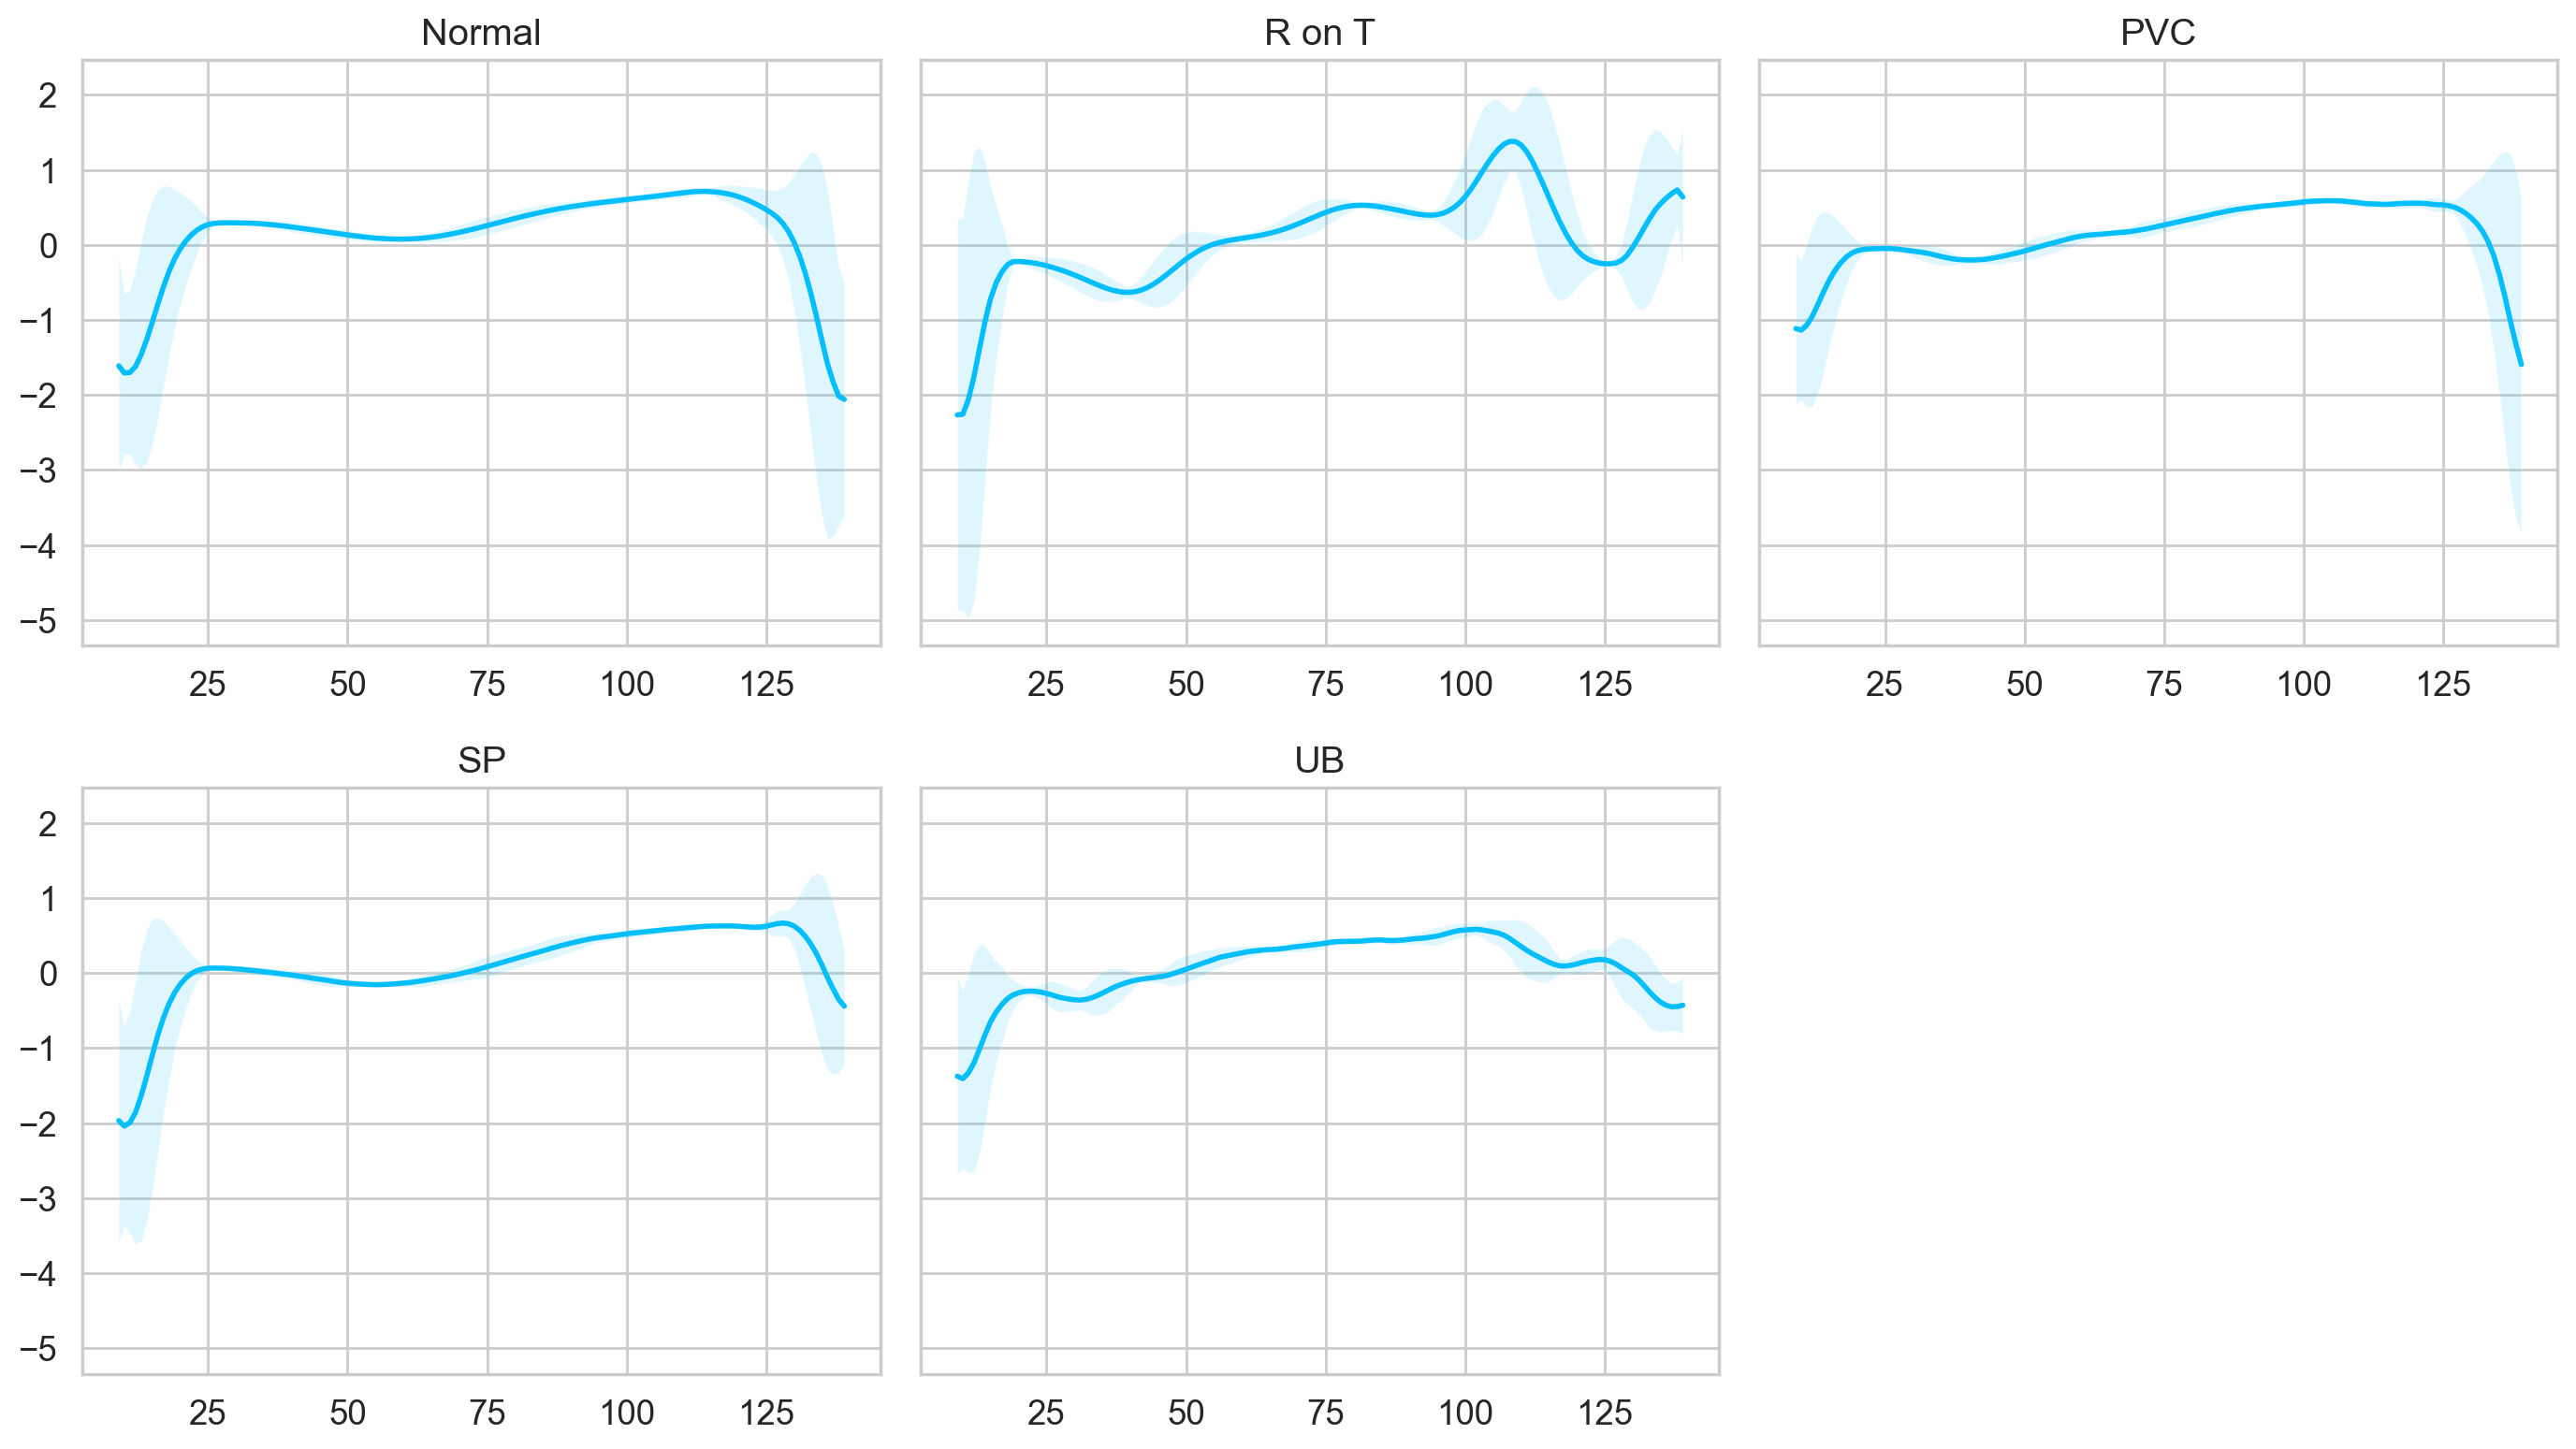

In [30]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [31]:
normal_df = df[df.target == str(CLASS_NORMAL)] #.drop(labels='target', axis=1)
#normal_target_df = df[df.target == str(CLASS_NORMAL)]['target'].copy()
normal_df.shape

(2919, 141)

We'll merge all other classes and mark them as anomalies:

In [32]:
anomaly_df = df[df.target != str(CLASS_NORMAL)] #.drop(labels='target', axis=1)
#anomaly_df_target = df[df.target != str(CLASS_NORMAL)]['target'].copy()
anomaly_df.shape

(2081, 141)

In [33]:
def drop_target(df):
  df = df.drop(labels="target",axis =1)
  return df

We'll split the normal examples into train, validation and test sets:

In [34]:
def normal_train_test_val_split(RANDOM_SEED):
  S_N_df, val_df = train_test_split(
    normal_df,
    test_size=0.15,
    random_state=RANDOM_SEED
  )

  V_N_df, T_N_df = train_test_split(
    val_df,
    test_size=0.33,
    random_state=RANDOM_SEED
  )
  V_N_df, V_N1_df = train_test_split(
    V_N_df,
    test_size=0.5,
    random_state=RANDOM_SEED
  )

  S_N_df = drop_target(S_N_df)
  V_N_df = drop_target(V_N_df)
  V_N1_df = drop_target(V_N1_df)
  return S_N_df, V_N_df, T_N_df

We'll split the anomaly into validation and test sets:





In [35]:
def anomaly_val_test_split(RANDOM_SEED):
  V_A_df, T_A_df = train_test_split(
      anomaly_df,
      test_size = 0.3,
      random_state = RANDOM_SEED
  )
  V_A_df, V_A1_df = train_test_split(
      V_A_df,
      test_size = 0.5,
      random_state = RANDOM_SEED
  )
  V_A_df = drop_target(V_A_df)
  V_A1_df = drop_target(V_A1_df)
  return V_A_df, T_A_df

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [36]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [37]:
def train_val_test_val_create(S_N_df, V_N_df, T_N_df, V_A_df, T_A_df):
  T_df = pd.concat([T_N_df, T_A_df])
  S_N_dataset, seq_len, n_features = create_dataset(S_N_df)
  V_N_dataset, _, _ = create_dataset(V_N_df)

  V_A_dataset, _, _ = create_dataset(V_A_df)

  T_target_df = T_df["target"]

  T_df = drop_target(T_df)
  T_dataset, _, _ = create_dataset(T_df)
  return S_N_dataset, seq_len, n_features, V_N_dataset, V_A_dataset, T_dataset, T_target_df


### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [67]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, rnn_type, embedding_dim=64, num_stages =2):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn_type = rnn_type
    self.num_stages = num_stages
    rnn_dict = {
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

    self.rnn_stages = nn.ModuleList() # a list to hold RNN_stages but not the last stage
    
    # input_size > hidden_size, cause in Encoder we want to compress the data, reduce the dimension into a  
    # representation, which can capture the most significant features and will be passed to the decoder
    self.rnn_stages.append(  # append the first stage cause input_size = n_features
      rnn_dict[self.rnn_type.upper()](
        input_size=self.n_features,
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True
      )
    )


    for i in range(1,num_stages-1): # append the rest stages except the last one
      self.rnn_stages.append(
      rnn_dict[self.rnn_type.upper()](
        input_size=self.hidden_dim, # diff from the first stage
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True
      )
      )

    # self.rnn1 = rnn_dict[self.rnn_type.upper()]( #GRU
    #   input_size=self.n_features,
    #   hidden_size=self.hidden_dim,
    #   num_layers=1,
    #   batch_first=True
    # )

    self.output_stage = rnn_dict[self.rnn_type.upper()]( # the last stage
      input_size=self.hidden_dim,
      hidden_size= self.embedding_dim,
      num_layers=1,
      batch_first=True
    )

    # self.rnn2 = rnn_dict[self.rnn_type.upper()]( #GRU
    #   input_size=self.hidden_dim,
    #   hidden_size= self.embedding_dim,
    #   num_layers=1,
    #   batch_first=True
    # )




  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    if self.rnn_type.upper() == "GRU" :
      for stage in self.rnn_stages:
        x,_ = stage(x)
      x,hidden_n = self.output_stage(x)

      # x, _,  = self.rnn1(x) # x, hidden_n
      # x, hidden_n  = self.rnn2(x) # x, hidden_n
    else:
      for stage in self.rnn_stages:
        x,(_,_) = stage(x)
      x,(hidden_n,_) = self.output_stage(x)

      # x, (_,_)  = self.rnn1(x) # x, hidden_n
      # x, (hidden_n,_)  = self.rnn2(x) # x, hidden_n
    hidden_n = hidden_n[-1]

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [71]:
class Decoder(nn.Module):

  def __init__(self, seq_len, type, input_dim=64, n_features=1, num_stages =2 ):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2*input_dim, n_features
    self.rnn_type = type
    self.num_stages = num_stages


    rnn_dict = {
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
    # input_size < hidden_size cause we want to reconstruct the original input from the passed representation
    # of the encoder
    self.rnn_stages = nn.ModuleList()
    for _ in range(num_stages -2 ):
        self.rnn_stages.append(
          rnn_dict[self.rnn_type.upper()]( #GRU
              input_size=input_dim,
              hidden_size=input_dim,
              num_layers=1,
              batch_first=True
            )
        )

    self.rnn_stages.append(rnn_dict[self.rnn_type.upper()]( #GRU
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    ))

    self.output_layer = nn.Linear(self.hidden_dim, self.n_features) # last stage

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    if self.rnn_type.upper() == "GRU" :
        for stage in self.rnn_stages:
            x, _ = stage(x)
        # x, _ = self.rnn1(x) # x, hidden_n
        # x, _ = self.rnn2(x) # x, hidden_n
    else:
        for stage in self.rnn_stages:
            x, (_,_) = stage(x)
        #x, (_, _) = self.rnn1(x)
        # x, (_, _) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [40]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, type, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features,type, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, type, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [41]:
def create_model(type,seq_len, n_features):
  model = RecurrentAutoencoder(seq_len, n_features, type, 128)
  model = model.to(device)
  return model

## Training

Let's write a helper function for our training process:

In [42]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true) # feed the model with the input (seq_true) to get the prediction(seq_predict)

        loss = criterion(seq_pred, seq_true) # calculate the diff between the input(seq_true)
                                            # and the predict of the model ( seq_pred)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [43]:
def trained_model(model, train_dataset, val_dataset):
  model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=2
  )
  return model,history

In [44]:
#ax = plt.figure().gca()

#ax.plot(history['train'])
#ax.plot(history['val'])
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['train', 'test'])
#plt.title('Loss over training epochs')
#plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [45]:
#MODEL_PATH = 'model.pth'

#torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [46]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [47]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

In [48]:
#_, losses = predict(model, train_dataset)

#sns.distplot(losses, bins=50, kde=True);

In [49]:
THRESHOLD = 26

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

In [50]:
#predictions, pred_losses = predict(model, test_normal_dataset)
#sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [51]:
#correct = sum(l <= THRESHOLD for l in pred_losses)
#print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [52]:
#anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
#anomaly_df_target_dataset = anomaly_df_target[:len(test_normal_dataset)]
#anomaly_arr = anomaly_df_target_dataset.to_numpy()
#int_array = anomaly_arr.astype(int)
#print(int_array)

Now we can take the predictions of our model for the subset of anomalies:

In [53]:
#anomaly_predictions, pred_losses = predict(model, anomaly_dataset)


In [54]:
def cal_AUC (target_data, pred_losses, type):
  arg = np.argsort(pred_losses) # arg[i] show the i+1 smallest lossvalue is pred_losses[arg[i]]
  rank = np.argsort(arg) # show that rank[i] is the rank of pred_losses[i]
  if type == "abnormal":
    indices = np.arange(len(target_data))[target_data != "1"]
  else:
    indices = np.arange(len(target_data))[target_data == "1"]
  n1 = len(indices)
  n2 = len(target_data) - n1
  if n1 ==0 or n2 ==0:
    print("fail")
    #raise Exception("Unable to calculate AUC score. Only elements of one class present.")
    return 0

  return (np.mean(rank[indices]) - (n1 +1)/2)/ n2

In [55]:
def create_data(seed):
  RANDOM_SEED = set_seed(seed)
  S_N_df, V_N_df, T_N_df = normal_train_test_val_split(RANDOM_SEED)
  V_A_df, T_A_df = anomaly_val_test_split(RANDOM_SEED)
  S_N_dataset, seq_len, n_features, V_N_dataset, V_A_dataset, T_dataset, T_target_df  = train_val_test_val_create(S_N_df, V_N_df, T_N_df, V_A_df, T_A_df)

  return S_N_dataset, seq_len, n_features, V_N_dataset, V_A_dataset, T_dataset, T_target_df


In [56]:
def AUC_and_predLoss(type,seq_len,n_features, S_N_dataset, V_N_dataset, T_dataset, T_target_df):
  model = create_model(type,seq_len, n_features) # create GRU and calculate AUC score then save it in AUC_df
  model,history = trained_model(model, S_N_dataset, V_N_dataset)
  _, pred_losses = predict(model, T_dataset)
  #Reconstruction_Error["GRU"] = pred_losses
  AUC_score = cal_AUC(T_target_df, pred_losses,"abnormal")
  #AUC["GRU"].append(AUC_GRU_score)
  return pred_losses, AUC_score

In [73]:
def AUC_df():
  AUC ={
      "GRU" : [],
      "LSTM" : []
  }
  Reconstruction_Error={
      "GRU" : [],
      "LSTM" :[]
  }
  for i in range(5): # create 20 GRU, LTSM and calculate AUC to evaluate the perfomences of these 2
    S_N_dataset, seq_len, n_features, V_N_dataset, V_A_dataset, T_dataset, T_target_df = create_data(i)
    #test_df_target = T_dataset[-1] # save the target column for testing
    #T_dataset = T_dataset[:-1] # drop the target column
    #.clone().int().numpy()
    #anomaly_dataset = T_A_dataset[:len(T_N_dataset)]
    #anomaly_df_target_dataset = anomaly_df_target[:len(T_N_dataset)]
    #anomaly_arr = anomaly_df_target_dataset.to_numpy()
    #anomaly_int_arr = anomaly_arr.astype(int)


    #model = create_model("GRU",seq_len, n_features) # create GRU and calculate AUC score then save it in AUC_df
    #model,history = trained_model(model, S_N_dataset, V_N_dataset)
    #_, pred_losses = predict(model, T_dataset)

    GRU_pred_losses, GRU_AUC_score = AUC_and_predLoss("GRU",seq_len,n_features, S_N_dataset, V_N_dataset, T_dataset, T_target_df)
    Reconstruction_Error["GRU"] = GRU_pred_losses
    #pred_losses, AUC_GRU_score = cal_AUC(test_df_target, pred_losses,"abnormal")
    AUC["GRU"].append(GRU_AUC_score)

    #model = create_model("LSTM",seq_len,n_features)
    #model,history = trained_model(model, S_N_dataset, V_N_dataset)
    #_, pred_losses = predict(model, T_dataset)
    #Reconstruction_Error["LSTM"] = pred_losses
    #LTSM_AUC_score = cal_AUC(test_df_target, pred_losses,"abnormal")


    LSTM_pred_losses, LSTM_AUC_score = AUC_and_predLoss("LSTM",seq_len,n_features, S_N_dataset, V_N_dataset, T_dataset, T_target_df)
    Reconstruction_Error["LSTM"] = LSTM_pred_losses
    #pred_losses, AUC_GRU_score = cal_AUC(test_df_target, pred_losses,"abnormal")
    AUC["LSTM"].append(LSTM_AUC_score)

    AUC_df = pd.DataFrame(AUC)
    Reconstruction_Error_df = pd.DataFrame(Reconstruction_Error)
    print(AUC["GRU"])
  return AUC_df,Reconstruction_Error_df


In [74]:
auc_df, Reconstruction_Error_df = AUC_df()

Epoch 1: train loss 57.297233939795476 val loss 55.80200169184437
Epoch 2: train loss 48.807376999953064 val loss 48.7016685956145
Epoch 1: train loss 64.49731140105968 val loss 54.502065736953526


KeyboardInterrupt: 

In [ ]:
def plot_boxplot ():

  auc_melted = auc_df.melt(var_name='Model', value_name='AUC')
  sns.boxplot(x='Model', y='AUC', data=auc_melted)
  plt.title('AUC Scores Comparison Across Models')
  plt.show()

In [ ]:
plot_boxplot()

In [ ]:
import scipy as sp
from scipy import stats
def threshold_set():
  mu, sigma = stats.norm.fit(Reconstruction_Error_df)
  threshold = mu + 3 * sigma

return threshold


Finally, we can count the number of examples above the threshold (considered as anomalies):

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)